Stochastic Modelling and Simulation project:
Multi-Robot Target Search using Probabilistic Consensus on Discrete Markov Chains.

In [13]:
import numpy as np
from Agent import Agent
from GridGraph import GridGraph
from DTMC_Utils import DTMC_Utils as utils

In [14]:
np.random.seed(12345)


Experimental parameter:

In [15]:
N = 3 # number of agents

alpha = 0.08 # to be chosen in (0, 1/d_max) <- d_max = N-1

map_width = 3 # (meters)
map_height = 3

S = map_width * map_height # number of nodes (locations)


Graph initialization:

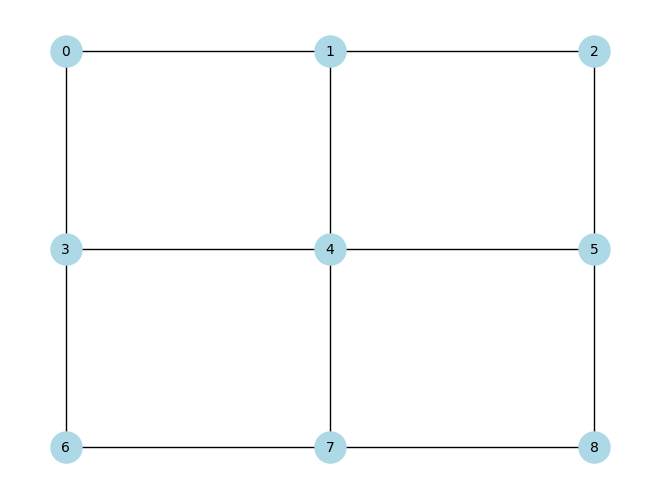

In [16]:
grid_graph = GridGraph(map_width, map_height)
grid_graph.plot_graph() 

Target init:

In [17]:
reference_information_state = 1
Z_r = [4, 5, 6] 
print("The reference information state is: " + str(reference_information_state))
print("Target is observable from nodes: " + str(Z_r))

The reference information state is: 1
Target is observable from nodes: [4, 5, 6]


Transition matrix:

In [18]:
P = utils.build_transition_matrix(grid_graph, S)

Agents init:

In [19]:
agents = []

for i in range(N):
    initial_node = np.random.randint(0, S)
    agent = Agent(i+1, initial_node)
    agents.append(agent)
    print(agent)

Agent ID: 1, 
Position: 2 
Information state: 0.8901547142593231

Agent ID: 2, 
Position: 1 
Information state: 0.18391881167709445

Agent ID: 3, 
Position: 5 
Information state: 0.5320779204036645


In [20]:
def build_graph_laplacian(actors):
    matrix =  np.zeros((N, N))
    for ii in range(N):
        matrix[ii][ii] = len(actors[ii].getNeighbors(actors))
    for j in range(N):
        for l in range(N):
            if j != l:
                if actors[j].getPosition() == actors[l].getPosition():
                    matrix[j][l] = -1
                else:
                    matrix[j][l] = 0
    print("Laplacian: ", matrix)
    return matrix

In [21]:
def build_augmented_information_state_vector(actors):
    vector = []
    for a in actors:
        vector.append(a.getInformationState())
    vector.append(reference_information_state)
    column_vector = np.array(vector).reshape(-1,1)
    print("information vector: ", column_vector)
    return column_vector

def build_transition_information_states_matrix(agent_list):
    L = build_graph_laplacian(agent_list)
    I = np.eye(N)
        
    # build d -> agent who finds the target
    d = []
    for index in range(N):
        if agent_list[index].getPosition() in Z_r:
            d.append(1)
        else:
            d.append(0)
    
    print("d = ", d)
    element_11 = I - alpha*L + np.diag(d)
    element_12 = [-x for x in d]  
    element_12_T = np.array(element_12).reshape(-1, 1)
    element_21 = np.zeros((1, N))
    element_22 = np.array([[1]])
    
    H = np.block([
        [element_11, element_12_T], [element_21, element_22]
    ])
    
    print("H = ", H)
    return H


In [22]:
def __cumulativeTransformer(p0:np.array)->np.array:
    """
    Given a probability array this function will compute the cumulative of such distribution.
    """
    p = np.zeros(len(p0),dtype=float)
    p[0] = p0[0]

    for i in range(1,len(p)):
        p[i] = p0[i] + p[i-1]
    
    return p

def obtainState(p0:np.array)->int:
    """
    Given a probability distribution of the state this function will
    produce a weighted random state.
    """
    p = __cumulativeTransformer(p0)

    random_state = np.random.uniform()
    s = 0
    for i in range(len(p0)):
        if (random_state < p[i]) and ((p[i] - p[i - 1]) > 0.0000001):
            s = i
            break           
    return s


In [23]:
class AgentController:
    
    def __init__(self, _agents, _graph, _reference_information_state):
        self.eps = 0.01
        self.agents = _agents
        self.graph = _graph
        self.reference_information_state = _reference_information_state
        self.k = 0
    
    def run(self):
        timer = 0
        while not self.check_consensus() and timer < 20:
            self.graph.plot_graph_with_agents(self.agents)
            H_k = build_transition_information_states_matrix(self.agents)
            actual_information_state_vector = build_augmented_information_state_vector(self.agents)
            
            new_information_state_vector = np.matmul(H_k, actual_information_state_vector)
            self.update_agents_position()
            self.update_agents_information_state(new_information_state_vector[:-1, :])
            
            timer+=1
            
        file_name = "trajectories.txt"
        with open(file_name, 'w') as file:
            stringa = ""
            for agent in self.agents:
                stringa += (f"Agent {agent.id_number}: \n State trajectory: {str(agent.getTrajectory())} \n Information state [k]:"
                            f" {np.array(agent.getInformationStateTrajectory()).__str__()} \n\n")
            file.write(stringa)
            
            # for _agent in self.agents:   
            #     sum1 = 0
            #     sum2 = 0
            #     N_ka = getNeighbors(_agent, agents)
            #     for b in N_ka:
            #         None # formula
            #     if _agent.getPosition() in Z_r:
            #         sum2 = -(_agent.getInformationState() - reference_information_state)
            #     
            #     information_state_k = _agent.getInformationState()
            #     _agent.updateInformationState(information_state_k + sum1 + sum2)
            #     print(build_graph_laplacian(self.agents))
            #     self.k += 1 # time
    
    def check_consensus(self):
        for ag in self.agents:
            if abs(ag.getInformationState() - self.reference_information_state) > self.eps:
                return False # at least one agent doesn't reach the reference state
        return True
    
    def update_agents_position(self):
        for agent in self.agents:
            actual_state = agent.getPosition()
            new_state = obtainState(P[actual_state].A1)
            agent.updatePosition(new_state)

    def update_agents_information_state(self, new_information_state):
        for (i, information_state) in enumerate(new_information_state):
            print(f"(i, information_state) = ({i},{information_state})")
            self.agents[i].updateInformationState(information_state[0])
            # self.agents[i].updateInformationState(max(information_state[0],0))


Graph class representing agent's environment

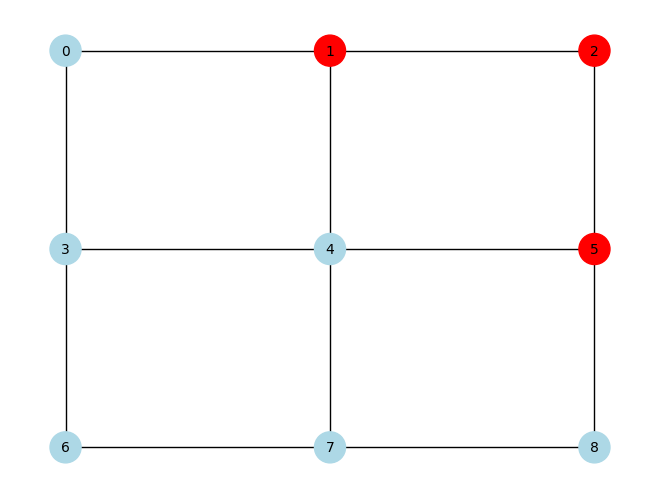

Laplacian:  [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
d =  [0, 0, 1]
H =  [[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  2. -1.]
 [ 0.  0.  0.  1.]]
information vector:  [[0.89015471]
 [0.18391881]
 [0.53207792]
 [1.        ]]
(i, information_state) = (0,[0.89015471])
(i, information_state) = (1,[0.18391881])
(i, information_state) = (2,[0.06415584])


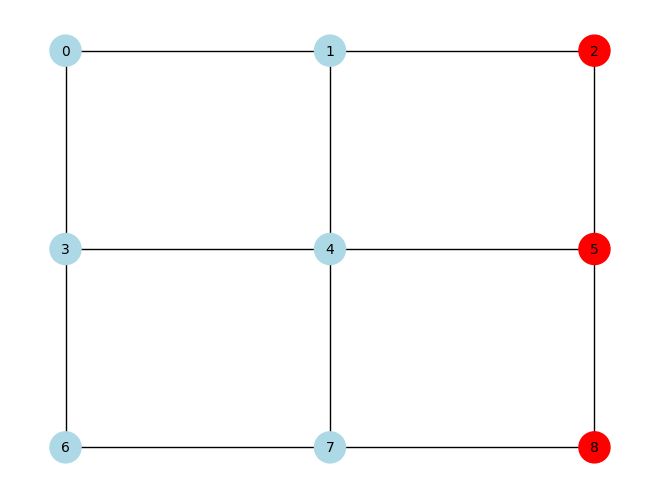

Laplacian:  [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
d =  [1, 0, 0]
H =  [[ 2.  0.  0. -1.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]
information vector:  [[0.89015471]
 [0.18391881]
 [0.06415584]
 [1.        ]]
(i, information_state) = (0,[0.78030943])
(i, information_state) = (1,[0.18391881])
(i, information_state) = (2,[0.06415584])


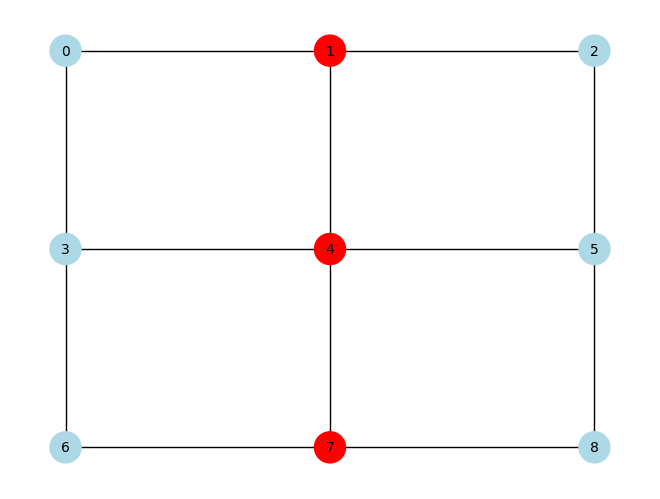

Laplacian:  [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
d =  [1, 0, 0]
H =  [[ 2.  0.  0. -1.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]
information vector:  [[0.78030943]
 [0.18391881]
 [0.06415584]
 [1.        ]]
(i, information_state) = (0,[0.56061886])
(i, information_state) = (1,[0.18391881])
(i, information_state) = (2,[0.06415584])


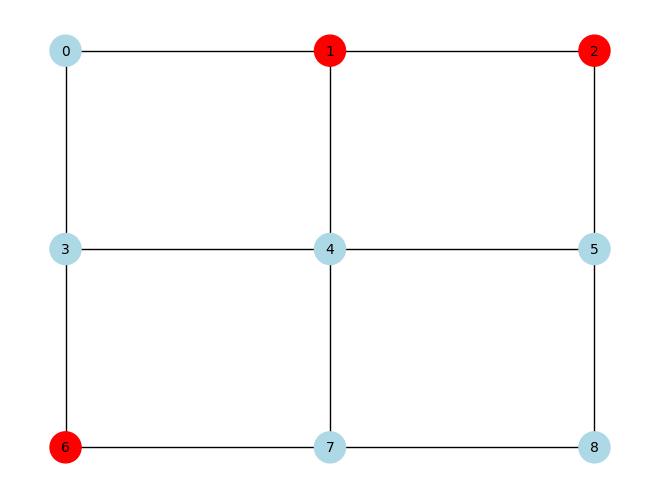

Laplacian:  [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
d =  [0, 0, 1]
H =  [[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  2. -1.]
 [ 0.  0.  0.  1.]]
information vector:  [[0.56061886]
 [0.18391881]
 [0.06415584]
 [1.        ]]
(i, information_state) = (0,[0.56061886])
(i, information_state) = (1,[0.18391881])
(i, information_state) = (2,[-0.87168832])


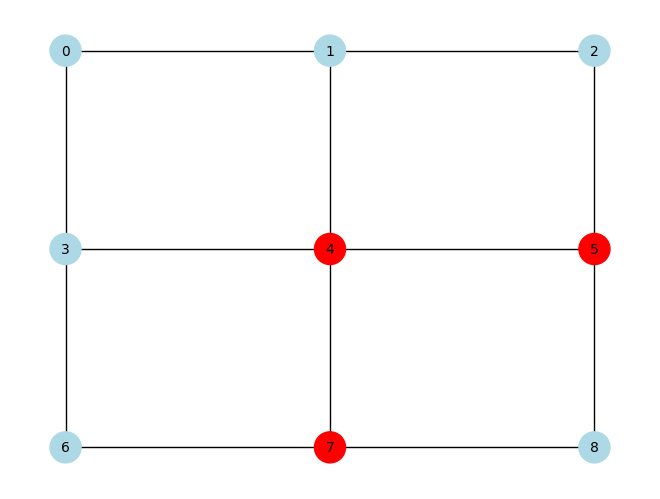

Laplacian:  [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
d =  [1, 1, 0]
H =  [[ 2.  0.  0. -1.]
 [ 0.  2.  0. -1.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]
information vector:  [[ 0.56061886]
 [ 0.18391881]
 [-0.87168832]
 [ 1.        ]]
(i, information_state) = (0,[0.12123771])
(i, information_state) = (1,[-0.63216238])
(i, information_state) = (2,[-0.87168832])


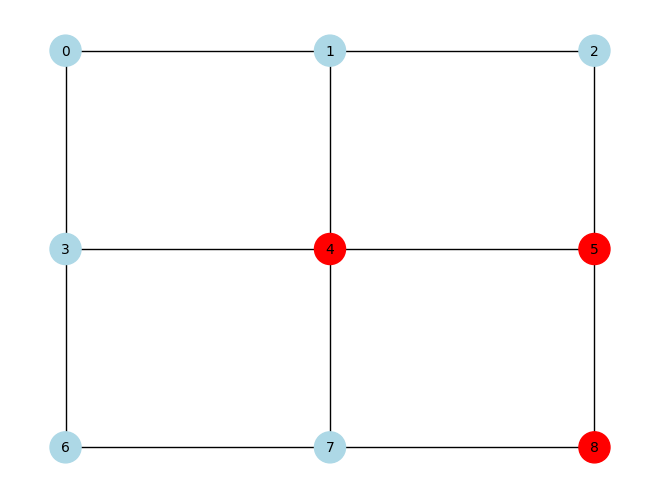

Laplacian:  [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
d =  [1, 0, 1]
H =  [[ 2.  0.  0. -1.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  2. -1.]
 [ 0.  0.  0.  1.]]
information vector:  [[ 0.12123771]
 [-0.63216238]
 [-0.87168832]
 [ 1.        ]]
(i, information_state) = (0,[-0.75752457])
(i, information_state) = (1,[-0.63216238])
(i, information_state) = (2,[-2.74337664])


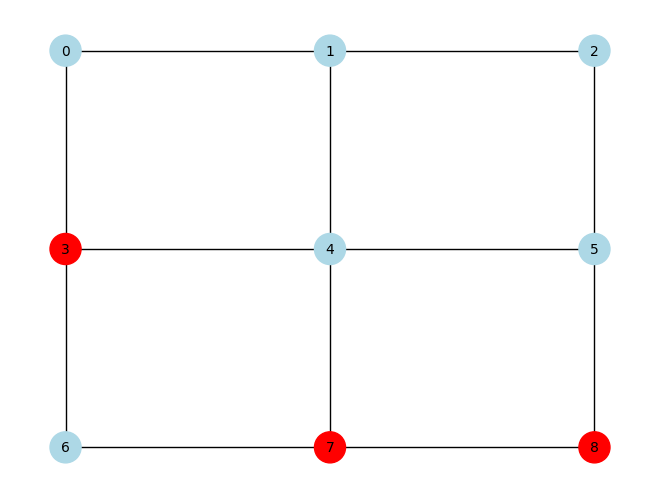

Laplacian:  [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
d =  [0, 0, 0]
H =  [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
information vector:  [[-0.75752457]
 [-0.63216238]
 [-2.74337664]
 [ 1.        ]]
(i, information_state) = (0,[-0.75752457])
(i, information_state) = (1,[-0.63216238])
(i, information_state) = (2,[-2.74337664])


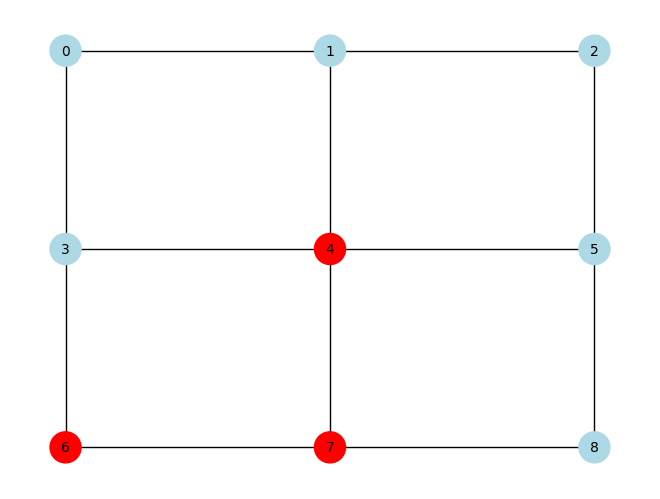

Laplacian:  [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
d =  [0, 1, 1]
H =  [[ 1.  0.  0.  0.]
 [ 0.  2.  0. -1.]
 [ 0.  0.  2. -1.]
 [ 0.  0.  0.  1.]]
information vector:  [[-0.75752457]
 [-0.63216238]
 [-2.74337664]
 [ 1.        ]]
(i, information_state) = (0,[-0.75752457])
(i, information_state) = (1,[-2.26432475])
(i, information_state) = (2,[-6.48675327])


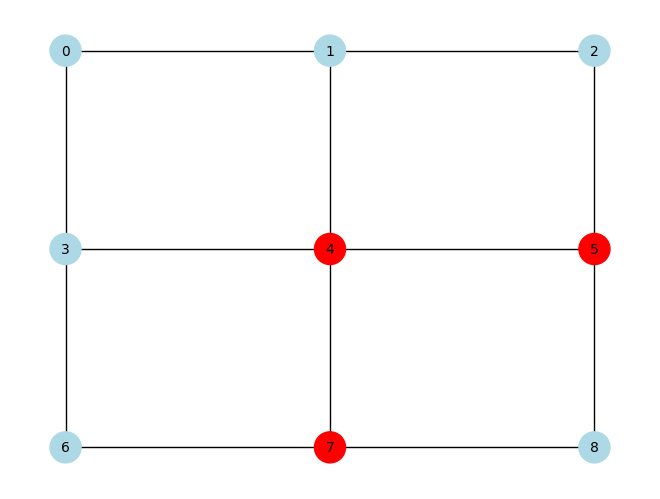

Laplacian:  [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
d =  [1, 1, 0]
H =  [[ 2.  0.  0. -1.]
 [ 0.  2.  0. -1.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]
information vector:  [[-0.75752457]
 [-2.26432475]
 [-6.48675327]
 [ 1.        ]]
(i, information_state) = (0,[-2.51504914])
(i, information_state) = (1,[-5.52864951])
(i, information_state) = (2,[-6.48675327])


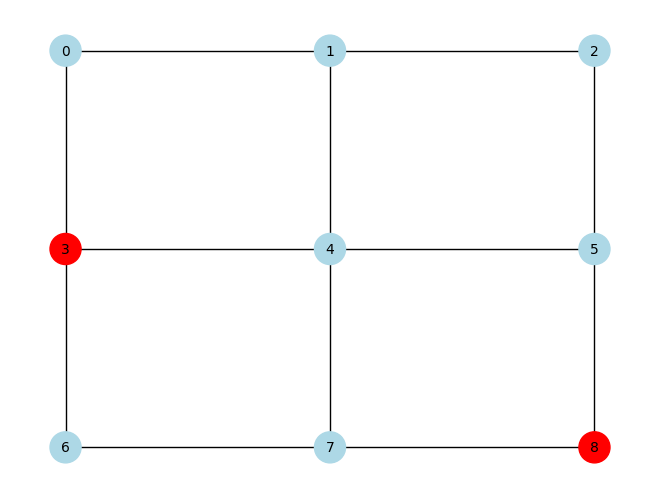

Laplacian:  [[ 0.  0.  0.]
 [ 0.  1. -1.]
 [ 0. -1.  1.]]
d =  [0, 0, 0]
H =  [[1.   0.   0.   0.  ]
 [0.   0.92 0.08 0.  ]
 [0.   0.08 0.92 0.  ]
 [0.   0.   0.   1.  ]]
information vector:  [[-2.51504914]
 [-5.52864951]
 [-6.48675327]
 [ 1.        ]]
(i, information_state) = (0,[-2.51504914])
(i, information_state) = (1,[-5.60529781])
(i, information_state) = (2,[-6.41010497])


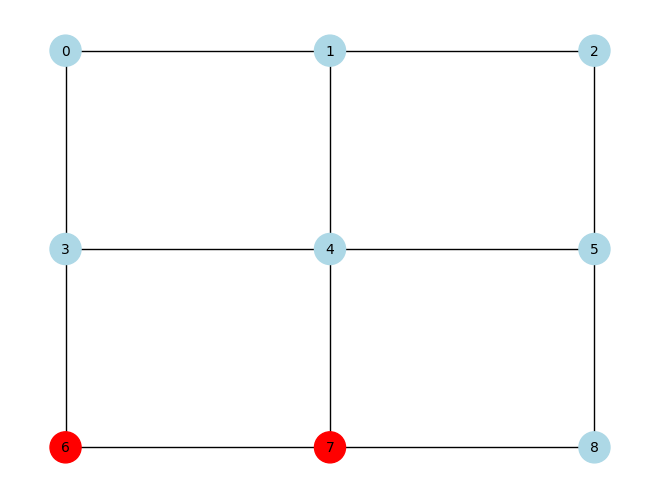

Laplacian:  [[ 0.  0.  0.]
 [ 0.  1. -1.]
 [ 0. -1.  1.]]
d =  [1, 0, 0]
H =  [[ 2.    0.    0.   -1.  ]
 [ 0.    0.92  0.08  0.  ]
 [ 0.    0.08  0.92  0.  ]
 [ 0.    0.    0.    1.  ]]
information vector:  [[-2.51504914]
 [-5.60529781]
 [-6.41010497]
 [ 1.        ]]
(i, information_state) = (0,[-6.03009829])
(i, information_state) = (1,[-5.66968238])
(i, information_state) = (2,[-6.3457204])


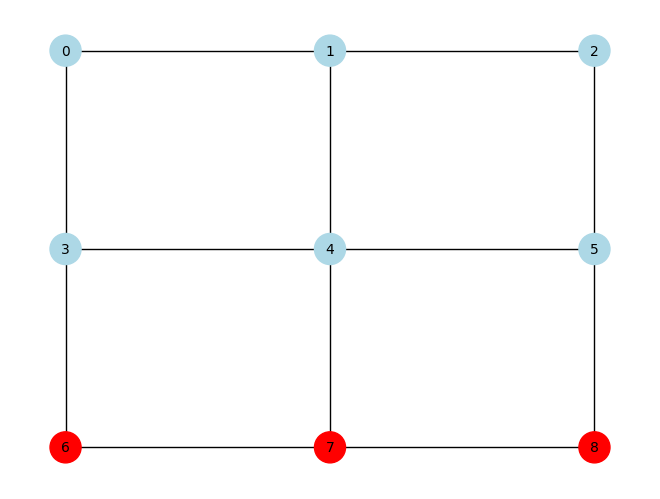

Laplacian:  [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
d =  [0, 0, 1]
H =  [[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  2. -1.]
 [ 0.  0.  0.  1.]]
information vector:  [[-6.03009829]
 [-5.66968238]
 [-6.3457204 ]
 [ 1.        ]]
(i, information_state) = (0,[-6.03009829])
(i, information_state) = (1,[-5.66968238])
(i, information_state) = (2,[-13.6914408])


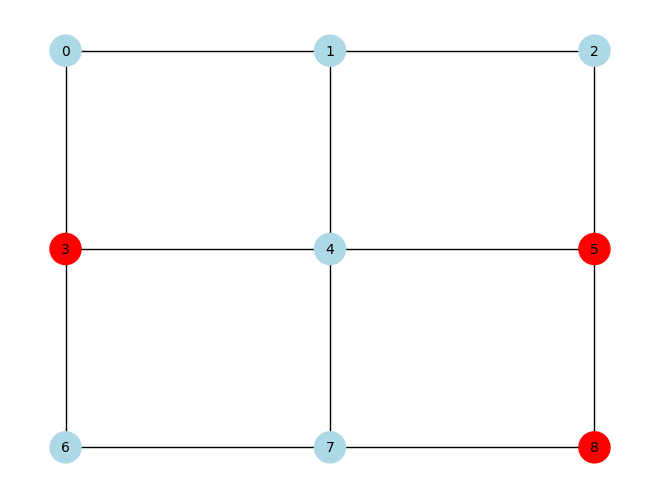

Laplacian:  [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
d =  [0, 1, 0]
H =  [[ 1.  0.  0.  0.]
 [ 0.  2.  0. -1.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]
information vector:  [[ -6.03009829]
 [ -5.66968238]
 [-13.6914408 ]
 [  1.        ]]
(i, information_state) = (0,[-6.03009829])
(i, information_state) = (1,[-12.33936476])
(i, information_state) = (2,[-13.6914408])


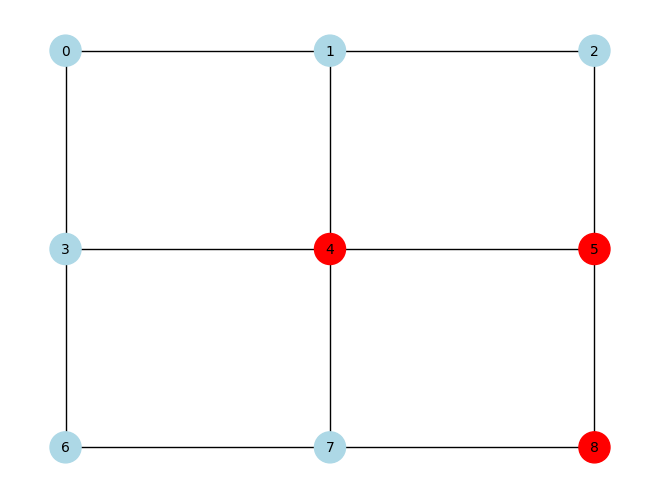

Laplacian:  [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
d =  [1, 0, 1]
H =  [[ 2.  0.  0. -1.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  2. -1.]
 [ 0.  0.  0.  1.]]
information vector:  [[ -6.03009829]
 [-12.33936476]
 [-13.6914408 ]
 [  1.        ]]
(i, information_state) = (0,[-13.06019657])
(i, information_state) = (1,[-12.33936476])
(i, information_state) = (2,[-28.3828816])


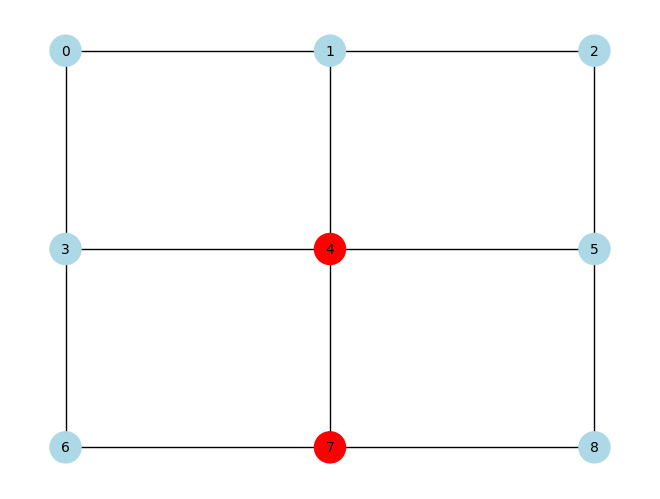

Laplacian:  [[ 0.  0.  0.]
 [ 0.  1. -1.]
 [ 0. -1.  1.]]
d =  [1, 0, 0]
H =  [[ 2.    0.    0.   -1.  ]
 [ 0.    0.92  0.08  0.  ]
 [ 0.    0.08  0.92  0.  ]
 [ 0.    0.    0.    1.  ]]
information vector:  [[-13.06019657]
 [-12.33936476]
 [-28.3828816 ]
 [  1.        ]]
(i, information_state) = (0,[-27.12039315])
(i, information_state) = (1,[-13.62284611])
(i, information_state) = (2,[-27.09940025])


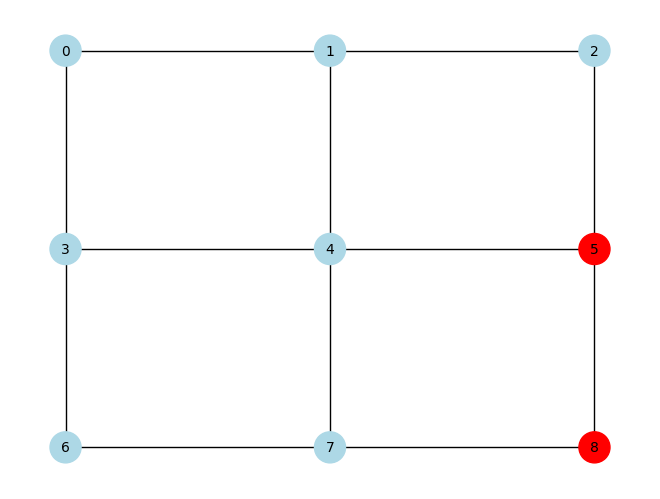

Laplacian:  [[ 0.  0.  0.]
 [ 0.  1. -1.]
 [ 0. -1.  1.]]
d =  [1, 0, 0]
H =  [[ 2.    0.    0.   -1.  ]
 [ 0.    0.92  0.08  0.  ]
 [ 0.    0.08  0.92  0.  ]
 [ 0.    0.    0.    1.  ]]
information vector:  [[-27.12039315]
 [-13.62284611]
 [-27.09940025]
 [  1.        ]]
(i, information_state) = (0,[-55.2407863])
(i, information_state) = (1,[-14.70097044])
(i, information_state) = (2,[-26.02127592])


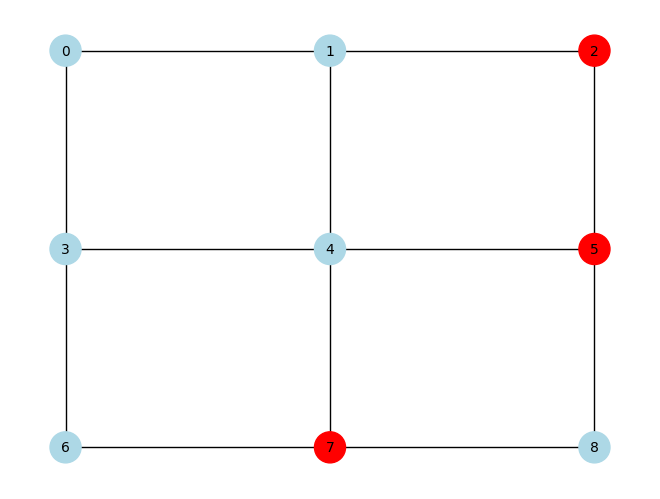

Laplacian:  [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
d =  [0, 0, 1]
H =  [[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  2. -1.]
 [ 0.  0.  0.  1.]]
information vector:  [[-55.2407863 ]
 [-14.70097044]
 [-26.02127592]
 [  1.        ]]
(i, information_state) = (0,[-55.2407863])
(i, information_state) = (1,[-14.70097044])
(i, information_state) = (2,[-53.04255184])


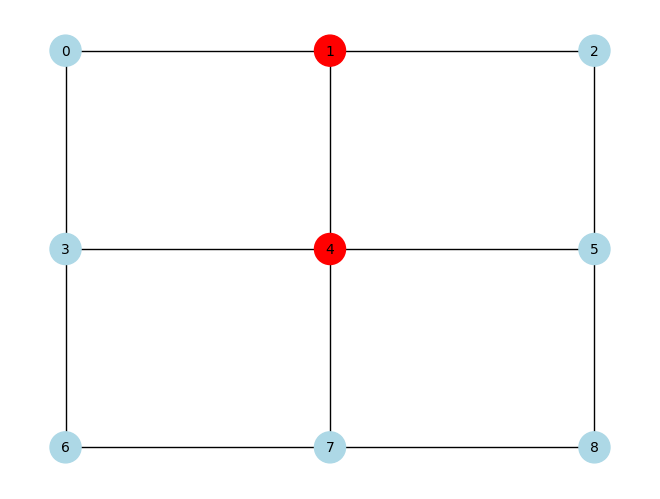

Laplacian:  [[ 0.  0.  0.]
 [ 0.  1. -1.]
 [ 0. -1.  1.]]
d =  [0, 1, 1]
H =  [[ 1.    0.    0.    0.  ]
 [ 0.    1.92  0.08 -1.  ]
 [ 0.    0.08  1.92 -1.  ]
 [ 0.    0.    0.    1.  ]]
information vector:  [[-55.2407863 ]
 [-14.70097044]
 [-53.04255184]
 [  1.        ]]
(i, information_state) = (0,[-55.2407863])
(i, information_state) = (1,[-33.46926739])
(i, information_state) = (2,[-104.01777716])


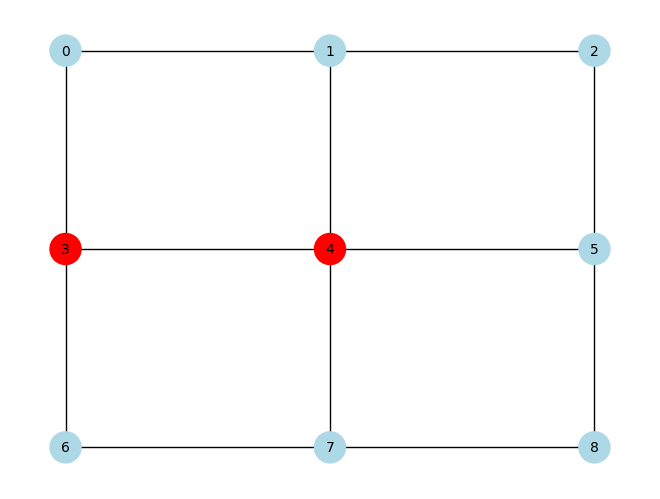

Laplacian:  [[ 0.  0.  0.]
 [ 0.  1. -1.]
 [ 0. -1.  1.]]
d =  [1, 0, 0]
H =  [[ 2.    0.    0.   -1.  ]
 [ 0.    0.92  0.08  0.  ]
 [ 0.    0.08  0.92  0.  ]
 [ 0.    0.    0.    1.  ]]
information vector:  [[ -55.2407863 ]
 [ -33.46926739]
 [-104.01777716]
 [   1.        ]]
(i, information_state) = (0,[-111.4815726])
(i, information_state) = (1,[-39.11314817])
(i, information_state) = (2,[-98.37389638])


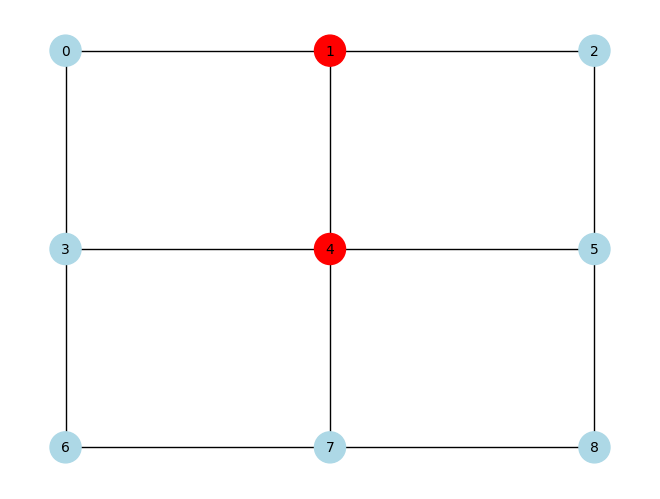

Laplacian:  [[ 0.  0.  0.]
 [ 0.  1. -1.]
 [ 0. -1.  1.]]
d =  [0, 1, 1]
H =  [[ 1.    0.    0.    0.  ]
 [ 0.    1.92  0.08 -1.  ]
 [ 0.    0.08  1.92 -1.  ]
 [ 0.    0.    0.    1.  ]]
information vector:  [[-111.4815726 ]
 [ -39.11314817]
 [ -98.37389638]
 [   1.        ]]
(i, information_state) = (0,[-111.4815726])
(i, information_state) = (1,[-83.9671562])
(i, information_state) = (2,[-193.0069329])


In [24]:
experiment = AgentController(agents, grid_graph, reference_information_state)
experiment.run()